In [13]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from bs4 import BeautifulSoup
import pysal as ps

%matplotlib inline

In [100]:
# List of MECS end uses
eu_list = ['Conventional Boiler Use', 'CHP and/or Cogeneration Process', 'Process Heating','Process Cooling and Refrigeration',
            'Machine Drive','Electro-Chemical Processes','Other Process Use','Direct Uses-Total Nonprocess']

In [101]:
# Data files
workingdir = "U:\\Industrial Heat Survey\\Paper Version\\Data and analysis\\Data for calculations\\"

target_energy_file = 'IHS_target_energydata_20170831.csv'

GHGRP_emissions = 'GHGRP_emissions_201015.csv'

target_eu_file = "C:\\Users\\cmcmilla\\Desktop\\GHGRP_output\\target_enduse.csv"

target_char_file = "C:\\Users\\cmcmilla\\Desktop\\GHGRP_output\\target_char.csv"

ghg_savings_file = 'target_ghgsavings.csv'

gr_op_file = 'GrossOutputIndex_TargetInd2.csv'

ind_desc_file = 'target_industries.csv'


In [102]:
# Load calculated energy data for target industries, GHGRP reported emissions values, and target industry energy by end use.

target_energy = pd.read_csv(workingdir + target_energy_file, encoding='latin_1', index_col=0, low_memory=False)

target_eu = pd.read_csv(target_eu_file, encoding='latin_1', index_col=0, low_memory=False)

target_char = pd.read_csv(target_char_file, encoding='latin_1', low_memory=False)

GHGRP_emissions = pd.read_csv(workingdir + GHGRP_emissions, encoding='latin_1')

GHGRP_emissions = pd.DataFrame(GHGRP_emissions[(GHGRP_emissions.SUBPART_NAME == 'C') |
                                               (GHGRP_emissions.SUBPART_NAME == 'D') |
                                               (GHGRP_emissions.SUBPART_NAME == 'AA')
                                              ])

GHGRP_emissions.rename(columns={'YEAR': 'REPORTING_YEAR'}, inplace=True)

In [94]:
# Label temperatures by low (<100°C), mid (100 - 400°C), or high (>400°C)
target_char.loc[:, 'Temp_Band'] = np.nan

target_char.loc[target_char[target_char.Temp_degC < 100].index, 'Temp_Band'] = '<100°C'

target_char.loc[target_char[target_char.Temp_degC > 400].index, 'Temp_Band'] = '>400°C'

target_char.loc[target_char[(target_char.Temp_degC >= 100) & 
                            (target_char.Temp_degC <= 400)].index, 'Temp_Band'] = '100 - 400°C'

In [103]:
target_char[target_char.Temp_degC < 100]

,Unnamed: 0,CITY,COUNTY,COUNTY_FIPS,Coal,Diesel,END_USE,FACILITY_ID,FINAL_NAICS_CODE,FUEL_TYPE,...,Residual_fuel_oil,STATE,Temp_degC,Total,UNIT_NAME,UNIT_TYPE,for_EU_sum,Temp_Band,Biogenic,MMTCO2E
60970,60970,LOUDON,Loudon,47105,0.000000,0.0,Conventional Boiler Use,1000401,311221,Natural Gas (Weighted U.S. Average),...,0.0,TN,50.0,76.058989,Coal Boiler #1 (PES-34),S (Stoker Boiler),True,<100°C,False,0.003829
60971,60971,LOUDON,Loudon,47105,0.000000,0.0,Conventional Boiler Use,1000401,311221,Natural Gas (Weighted U.S. Average),...,0.0,TN,50.0,490.596244,GP-1,OCS (Other combustion source),True,<100°C,False,0.024698
60972,60972,LOUDON,Loudon,47105,0.000000,0.0,Conventional Boiler Use,1000401,311221,Natural Gas (Weighted U.S. Average),...,0.0,TN,50.0,79.101348,Coal Boiler #2 (PES-35),S (Stoker Boiler),True,<100°C,False,0.003982
60973,60973,KEOKUK,LEE,19111,0.000000,0.0,Conventional Boiler Use,1001293,311221,Natural Gas (Weighted U.S. Average),...,0.0,IA,50.0,483.172681,GP-01,OCS (Other combustion source),True,<100°C,False,0.024324
60974,60974,KEOKUK,LEE,19111,0.000000,0.0,Conventional Boiler Use,1001293,311221,Natural Gas (Weighted U.S. Average),...,0.0,IA,50.0,0.305612,GP-02,OCS (Other combustion source),True,<100°C,False,0.000015
60975,60975,KEOKUK,LEE,19111,0.000000,0.0,Conventional Boiler Use,1001293,311221,Natural Gas (Weighted U.S. Average),...,0.0,IA,50.0,30.423595,121 CFB Boiler,"CFB (Boiler, circulating fluidized bed)",True,<100°C,False,0.001532
60976,60976,CEDAR RAPIDS,LINN COUNTY,19113,0.000000,0.0,Conventional Boiler Use,1002632,311221,Natural Gas (Weighted U.S. Average),...,0.0,IA,50.0,708.968968,GP-001-NG,OCS (Other combustion source),True,<100°C,False,0.035692
60977,60977,LAFAYETTE,TIPPECANOE,18157,0.000000,0.0,Conventional Boiler Use,1005988,311221,Natural Gas (Weighted U.S. Average),...,0.0,IN,50.0,551.890672,GP-01,OCS (Other combustion source),True,<100°C,False,0.027784
60978,60978,LAFAYETTE,TIPPECANOE COUNTY,18157,0.000000,0.0,Conventional Boiler Use,1001675,311221,Natural Gas (Weighted U.S. Average),...,0.0,IN,50.0,182.335155,GP-01,OCS (Other combustion source),True,<100°C,False,0.009179
60979,60979,DECATUR,Macon,17115,0.000000,0.0,Conventional Boiler Use,1000334,311221,Natural Gas (Weighted U.S. Average),...,0.0,IL,50.0,0.000000,Boiler #1 (123-08),"CFB (Boiler, circulating fluidized bed)",True,<100°C,False,0.000000


In [105]:
# Count number of reporting facilities for 2015
target_char[target_char.REPORTING_YEAR == 2015].drop_duplicates(
    'FACILITY_ID'
    ).groupby(['FINAL_NAICS_CODE']).FACILITY_ID.count()


FINAL_NAICS_CODE
212391     11
311221     24
322110     33
322121    118
322130     72
324110    144
325110     37
325181     12
325193    177
325199     98
325211     73
325311     30
327410     50
331111    114
Name: FACILITY_ID, dtype: int64

In [106]:
# Format GHGRP-reported emissions
GHGRP_emissions.loc[:, 'FINAL_NAICS_CODE'] = GHGRP_emissions.FACILITY_ID.map(
    dict(target_energy[['FACILITY_ID', 'FINAL_NAICS_CODE']].values)
    )

GHGRP_emissions.dropna(subset = ['FINAL_NAICS_CODE'], inplace=True)

GHGRP_emissions.loc[:, 'FINAL_NAICS_CODE'] = [int(x) for x in GHGRP_emissions.FINAL_NAICS_CODE.values]

emissions_summary = pd.DataFrame(GHGRP_emissions.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE']).CO2E_EMISSION.sum())



In [107]:
# Group by reporting year and NAICS code, including GHGRP-reported emissions, and convert to TJ
ind_summary = pd.DataFrame(target_energy.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE']).MMBtu_TOTAL.sum() * 0.001055)

for g in emissions_summary.index:
    ind_summary.loc[g, 'CO2E_EMISSION'] = emissions_summary.to_dict(orient='index')[g]['CO2E_EMISSION']
    
ind_summary.rename(columns = {'MMBtu_TOTAL': 'TJ_TOTAL'}, inplace=True)

ind_index_val = pd.DataFrame()

for y in ind_summary.index.levels[0]:
    ind_index_val = ind_index_val.append(
        ind_summary[ind_summary.index.get_level_values('REPORTING_YEAR') == y].divide(
                ind_summary[ind_summary.index.get_level_values('REPORTING_YEAR') == 2010].values, axis = 0
                ) * 100
              )

# Index NAICS 311221 and NAICS 325193 to 2011 values based on missing facility data for 2010
def New_index_vals(naics, year, ind_index_val):
    
    new_vals = ind_summary[ind_summary.index.get_level_values('FINAL_NAICS_CODE') == naics].divide(
        ind_summary.loc[year, naics].values
        ) * 100
    
    new_vals.drop(new_vals[new_vals.index.get_level_values('REPORTING_YEAR') == 2010].index, inplace=True)
    
    ind_index_val.drop(ind_index_val[ind_index_val.index.get_level_values('FINAL_NAICS_CODE') == naics].index, inplace=True)
    
    for y in ind_index_val.index.levels[0][1:]:
        ind_index_val = ind_index_val.append(new_vals.loc[y, naics])
        
    return ind_index_val


ind_index_val = New_index_vals(311221, 2011, ind_index_val)

ind_index_val = New_index_vals(325193, 2011, ind_index_val)
    
#index_val311221 = \
#    ind_summary[ind_summary.index.get_level_values('FINAL_NAICS_CODE') == 311221].divide(ind_summary.loc[2011, 311221].values) \
#    * 100

#index_val311221.drop(index_val311221[index_val311221.index.get_level_values('REPORTING_YEAR') == 2010].index, inplace=True)

#ind_index_val.drop(ind_index_val[ind_index_val.index.get_level_values('FINAL_NAICS_CODE') == 311221].index, inplace=True)

#for y in ind_index_val.index.levels[0][1:]:
#    ind_index_val = ind_index_val.append(index_val311221.loc[y, 311221])

ind_index_val.rename(columns = {'TJ_TOTAL': 'TJ_index', 'CO2E_EMISSION': 'CO2E_index'}, inplace=True)

ind_index_val.reset_index(inplace=True)

ind_index_val = pd.DataFrame(
    ind_index_val[['TJ_index', 'CO2E_index']].values, index=[ind_index_val.REPORTING_YEAR, ind_index_val.FINAL_NAICS_CODE],
    columns=['TJ_index', 'CO2E_index']
    )

ind_summary = pd.concat([ind_summary, ind_index_val], axis=1)

ind_summary.reset_index(inplace=True)

ind_summary= pd.melt(
    ind_summary, id_vars = ['REPORTING_YEAR', 'FINAL_NAICS_CODE'], \
    value_vars = ['TJ_TOTAL', 'CO2E_EMISSION', 'TJ_index', 'CO2E_index']
    )

ind_summary_fuels = \
    pd.DataFrame(target_energy.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE', 'MECS_FT']).MMBtu_TOTAL.sum() * 0.001055)

ind_summary_fuels.reset_index(inplace=True)

ind_summary_fuels.rename(columns={'MECS_FT': 'variable', 'MMBtu_TOTAL': 'value'}, inplace=True)

ind_summary = ind_summary.append(ind_summary_fuels)

ind_summary.dropna(axis=0, how='any', inplace=True)

# Import gross output indices and append to energy and emissions index dataframe.
grout = pd.read_csv(workingdir + gr_op_file)

grout.fillna(method='ffill', axis=0, inplace=True)

grout.loc[:, 'FINAL_NAICS_CODE'] = grout.FINAL_NAICS_CODE.apply(lambda x: int(x))

ind_summary = ind_summary.append(grout, ignore_index=True)

target_desc_dict = dict(pd.read_csv(workingdir + ind_desc_file).values)

ind_summary.loc[:, 'NAICS_desc'] = ind_summary.FINAL_NAICS_CODE.map(target_desc_dict) 

In [108]:
# Summary table of annual calculated energy use and reported emissions

E_E_summary = pd.pivot_table(ind_summary[(ind_summary.variable == 'TJ_TOTAL') | 
                (ind_summary.variable == 'CO2E_EMISSION')],
               index='NAICS_desc', columns=['REPORTING_YEAR', 'variable'],
               values='value', aggfunc='sum'
               )

E_E_summary.apply(lambda x: np.round(x,0)).to_csv('E_E_summary.csv')



In [109]:
E_E_summary

REPORTING_YEAR                                          2010                \
variable                                       CO2E_EMISSION      TJ_TOTAL   
NAICS_desc                                                                   
Alkalies and Chlorine Manufacturing             1.329773e+07  2.472383e+05   
All Other Basic Organic Chemical Manufacturing  2.303647e+07  4.067664e+05   
Ethyl Alcohol Manufacturing                     1.836236e+07  1.973573e+05   
Iron and Steel Mills                            5.219414e+07  4.697104e+05   
Lime Manufacturing                              1.009314e+07  1.105841e+05   
Nitrogenous Fertilizer Manufacturing            1.020010e+07  1.953884e+05   
Paper (except Newsprint) Mills                  7.292728e+07  4.643468e+05   
Paperboard Mills                                4.794417e+07  2.827648e+05   
Petrochemical Manufacturing                     1.525276e+07  2.652531e+05   
Petroleum Refineries                            1.269980e+08  2.246441e+06   
Plastics Material and Resin Manufacturing       1.641436e+07  2.571450e+05   
Potash, Soda, and Borate Mineral Mining         5.775441e+06  7.741345e+04   
Pulp Mills                                      4.311646e+07  1.824729e+05   
Wet Corn Milling                                1.673788e+07  5.689949e+04   

REPORTING_YEAR                                          2011                \
variable                                       CO2E_EMISSION      TJ_TOTAL   
NAICS_desc                                                                   
Alkalies and Chlorine Manufacturing             1.322005e+07  2.550801e+05   
All Other Basic Organic Chemical Manufacturing  2.280450e+07  4.248716e+05   
Ethyl Alcohol Manufacturing                     1.883985e+07  3.550876e+05   
Iron and Steel Mills                            5.607048e+07  4.997442e+05   
Lime Manufacturing                              1.041385e+07  1.156555e+05   
Nitrogenous Fertilizer Manufacturing            1.048751e+07  2.014456e+05   
Paper (except Newsprint) Mills                  7.212789e+07  4.780330e+05   
Paperboard Mills                                4.743095e+07  2.854220e+05   
Petrochemical Manufacturing                     1.607283e+07  2.931548e+05   
Petroleum Refineries                            1.263778e+08  2.245275e+06   
Plastics Material and Resin Manufacturing       1.833937e+07  3.006768e+05   
Potash, Soda, and Borate Mineral Mining         5.839132e+06  8.009209e+04   
Pulp Mills                                      4.272426e+07  1.729934e+05   
Wet Corn Milling                                1.742285e+07  1.945619e+05   

REPORTING_YEAR                                          2012                \
variable                                       CO2E_EMISSION      TJ_TOTAL   
NAICS_desc                                                                   
Alkalies and Chlorine Manufacturing             1.315085e+07  2.534180e+05   
All Other Basic Organic Chemical Manufacturing  2.256608e+07  4.312673e+05   
Ethyl Alcohol Manufacturing                     1.782552e+07  3.385579e+05   
Iron and Steel Mills                            5.186469e+07  4.720186e+05   
Lime Manufacturing                              1.009128e+07  1.132892e+05   
Nitrogenous Fertilizer Manufacturing            1.010361e+07  1.939857e+05   
Paper (except Newsprint) Mills                  7.134701e+07  4.852767e+05   
Paperboard Mills                                4.756425e+07  2.859208e+05   
Petrochemical Manufacturing                     1.563393e+07  2.844684e+05   
Petroleum Refineries                            1.228833e+08  2.232271e+06   
Plastics Material and Resin Manufacturing       1.779004e+07  2.914161e+05   
Potash, Soda, and Borate Mineral Mining         5.928426e+06  8.147871e+04   
Pulp Mills                                      4.254371e+07  1.689926e+05   
Wet Corn Milling                                1.727295e+07  2.182696e+05   

REPORTING_YEAR     

In [110]:
ind_summary.variable.drop_duplicates()

intensity = pd.DataFrame(
    ind_summary[(ind_summary.variable == 'TJ_TOTAL') | 
                (ind_summary.variable == 'CO2E_EMISSION') | 
                (ind_summary.variable == 'GrossOutput_MUSD') | 
                (ind_summary.variable == 'GrossOutput_MUSD_agg')]
    )

intensity.drop(['FINAL_NAICS_CODE', 'Unnamed: 1'], inplace=True, axis=1)

intensity = pd.pivot_table(intensity, index=['REPORTING_YEAR', 'NAICS_desc'], values='value', columns='variable')

intensity.dropna(axis=0, thresh=1, inplace=True, subset=['GrossOutput_MUSD','GrossOutput_MUSD_agg' ])

intensity.loc[:, 'CO2E Intensity (Aggregate)'] = intensity.CO2E_EMISSION.divide(intensity.GrossOutput_MUSD_agg)

intensity.loc[:, 'Energy Intensity (Aggregate)'] = intensity.TJ_TOTAL.divide(intensity.GrossOutput_MUSD_agg)

intensity.loc[:, 'CO2E Intensity'] = intensity.CO2E_EMISSION.divide(intensity.GrossOutput_MUSD)

intensity.loc[:, 'Energy Intensity'] = intensity.TJ_TOTAL.divide(intensity.GrossOutput_MUSD)


In [111]:
# Calculate change in intensities from 2010 or 2011 to 2015

def inten_change(end_year, start_year):
    
    perc_change = \
        intensity.loc[end_year, intensity.columns[4:]].divide(intensity.loc[start_year, intensity.columns[4:]]) - 1
    
    return perc_change

print(2010, inten_change(2015, 2010), "\n", 2011, inten_change(2015, 2011))


2010 variable                                        CO2E Intensity (Aggregate)  \
NAICS_desc                                                                   
Alkalies and Chlorine Manufacturing                              -0.178005   
All Other Basic Organic Chemical Manufacturing                   -0.105619   
Ethyl Alcohol Manufacturing                                            NaN   
Iron and Steel Mills                                             -0.059011   
Lime Manufacturing                                               -0.377120   
Nitrogenous Fertilizer Manufacturing                             -0.483245   
Paper (except Newsprint) Mills                                   -0.091363   
Paperboard Mills                                                       NaN   
Petrochemical Manufacturing                                            NaN   
Petroleum Refineries                                                   NaN   
Plastics Material and Resin Manufacturing                  

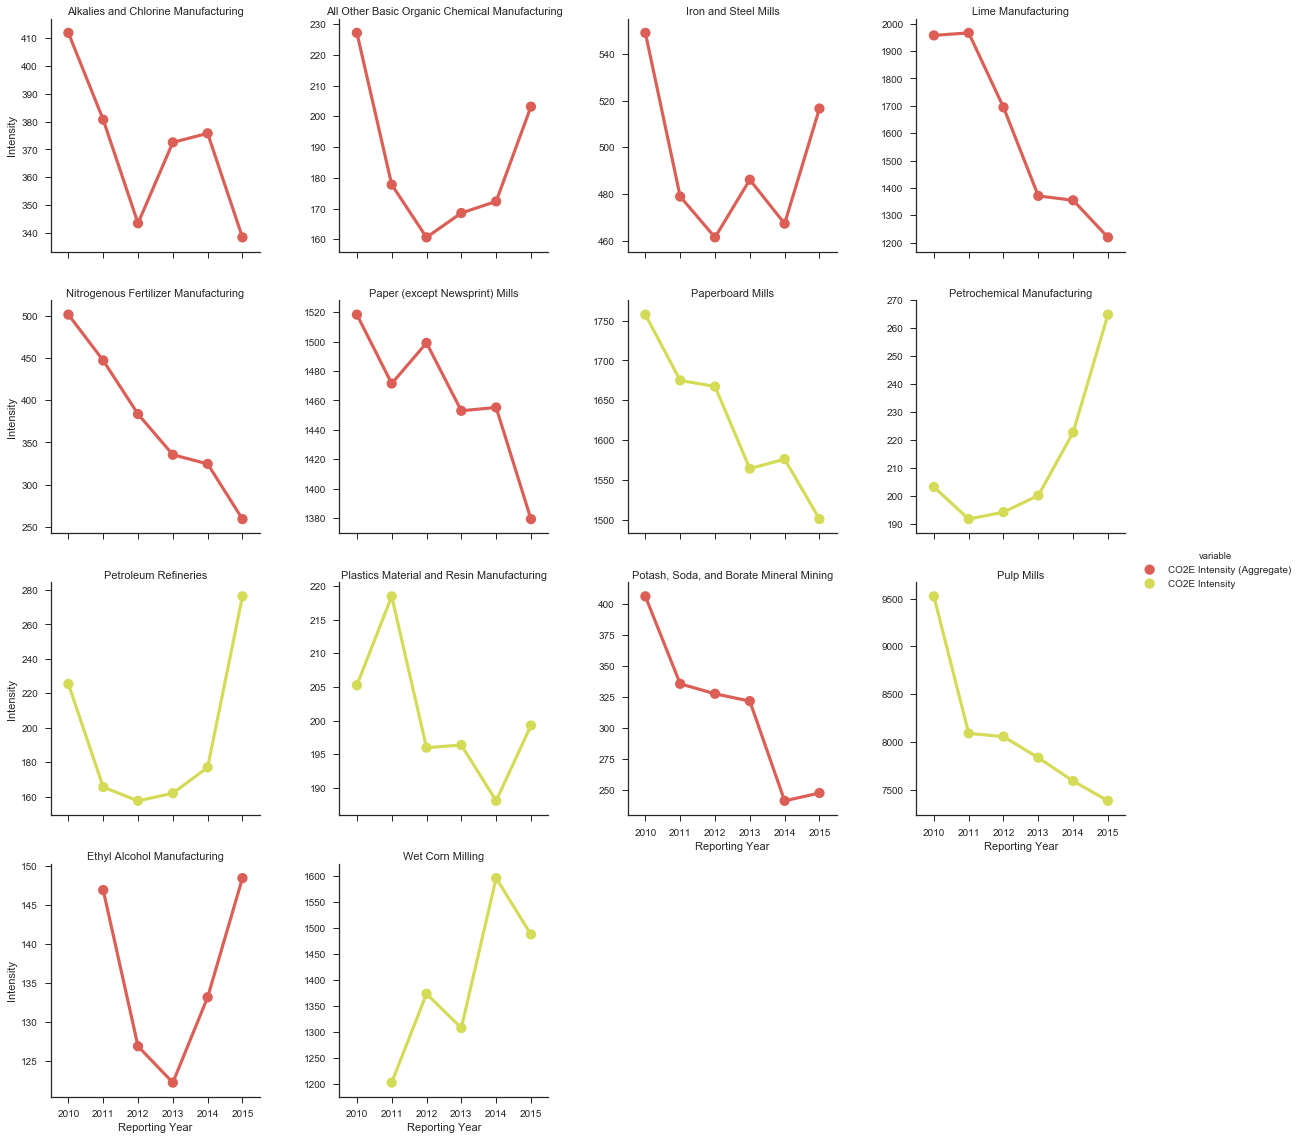

In [112]:
# Plot calculated energy or emissions intenity per Gross Output (million USD)

sns.set(style = 'ticks')
sns.set_palette('hls')
sns.set_context('notebook')
sns.hls_palette(3, l=.3, s=.8)



g_intensity_data = pd.DataFrame(
    intensity[[
                'CO2E Intensity (Aggregate)', 'CO2E Intensity']]
    )

g_intensity_data.reset_index(inplace=True)

g_intensity_data = pd.melt(g_intensity_data, id_vars=['REPORTING_YEAR', 'NAICS_desc'])

g_intensity = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'NAICS_desc', col_wrap = 4, hue = 'variable',
    data = g_intensity_data, legend_out=True, sharey=False,
    )

g_intensity.set_axis_labels('Reporting Year', 'Intensity')

g_intensity.set_titles('{col_name}')


In [113]:
# Calculate dataframe for fuel type fraction of total calculate energy.
ind_summary_fuelfrac = ind_summary_fuels.set_index(['REPORTING_YEAR', 'FINAL_NAICS_CODE'], drop=True)

for i in ind_summary_fuelfrac.index.drop_duplicates():
            ind_summary_fuelfrac.loc[i, 'total'] = \
                ind_summary[(ind_summary.REPORTING_YEAR == i[0]) & 
                        (ind_summary.FINAL_NAICS_CODE == i[1]) & 
                        (ind_summary.variable == 'TJ_TOTAL')].value.values[0]

ind_summary_fuelfrac.loc[:, 'value'] = ind_summary_fuelfrac['value'].divide(ind_summary_fuelfrac['total'])

ind_summary_fuelfrac.reset_index(inplace=True)

ind_summary_fuelfrac.drop('total', inplace=True, axis=1)

ind_summary_fuelfrac.loc[:, 'NAICS_desc'] = ind_summary_fuelfrac.FINAL_NAICS_CODE.map(target_desc_dict) 

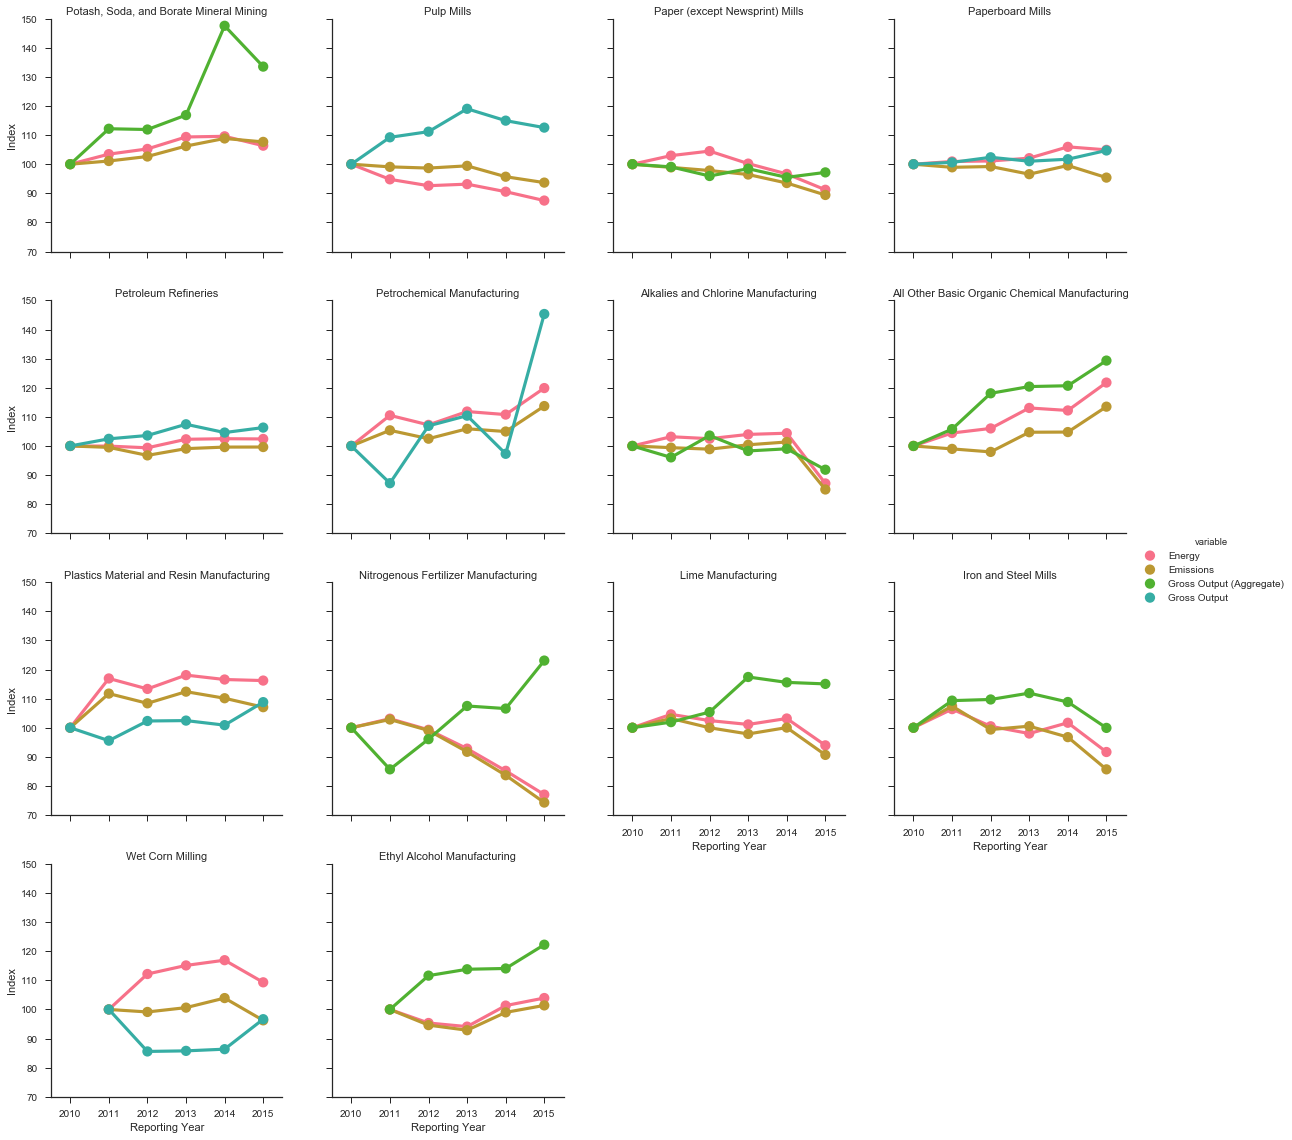

In [114]:
# Plot annual index values for reported GHG emissions, calculated energy values, and gross output (Bureau of Economic Analysis)

sns.set(style = 'ticks')
sns.set_palette('husl')
sns.set_context('notebook')
sns.husl_palette(4, l=.3, s=.8)

g_emissions_data = pd.DataFrame(ind_summary[(ind_summary.variable == 'CO2E_index') | (ind_summary.variable == 'TJ_index') | 
                       (ind_summary.variable == 'GrossOutput_index') | 
                       (ind_summary.variable == 'GrossOutput_index_agg')])

g_emissions_data.replace(
    {'CO2E_index': 'Emissions', 'TJ_index': 'Energy',
     'GrossOutput_index': 'Gross Output', 'GrossOutput_index_agg': 'Gross Output (Aggregate)'},
    inplace=True
)

g_emissions = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'NAICS_desc', col_wrap = 4, hue = 'variable',
    data = g_emissions_data, legend_out=True
    )

g_emissions.set_axis_labels('Reporting Year', 'Index')

g_emissions.set_titles('{col_name}')

g_emissions.set(ylim=(70, 150))

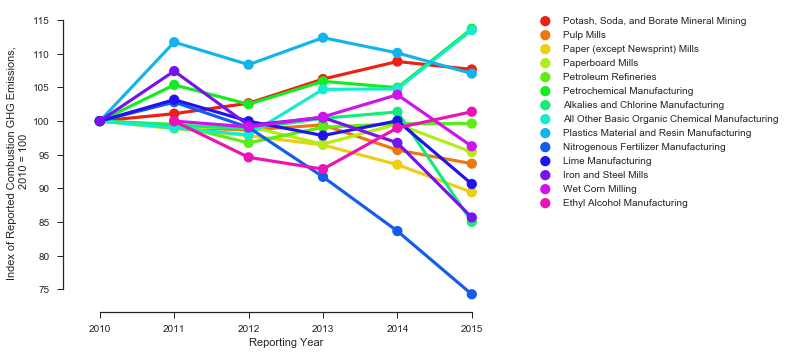

In [115]:
# Plot industry index of GHGRP-reported emissions
# Set Seaborn plot styles
sns.set_style('ticks')
sns.set_context('notebook')

em_index = sns.pointplot(
    x = 'REPORTING_YEAR', y = 'value', hue = 'NAICS_desc',
    data = ind_summary[ind_summary.variable == 'CO2E_index'], palette = sns.hls_palette(15, l=.5, s=.85)
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

em_index.set(xlabel='Reporting Year', ylabel='Index of Reported Combustion GHG Emissions,\n 2010 = 100')

sns.despine(trim = True)

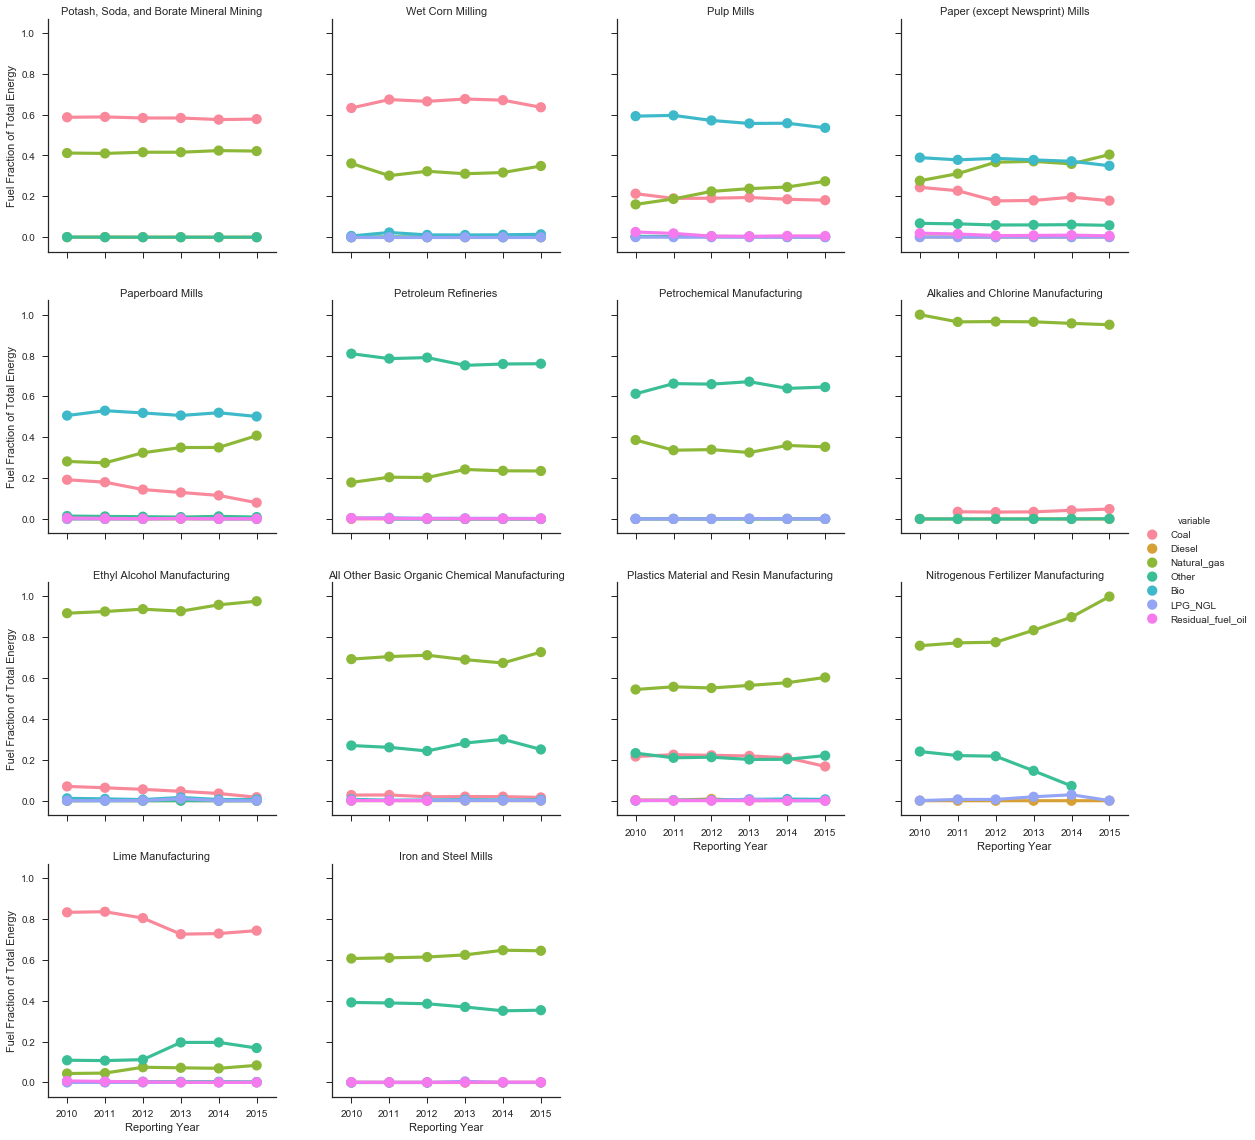

In [116]:
# Plot fuel fraction of total calculated energy by year and NAICS
sns.set(style = 'ticks')
sns.set_palette('colorblind')
sns.hls_palette(8, l=.3, s=.8)

g_fuels = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'NAICS_desc', col_wrap = 4, hue = 'variable', kind='point',
    data = ind_summary_fuelfrac)

g_fuels.set_titles('{col_name}')

g_fuels.set_axis_labels('Reporting Year', 'Fuel Fraction of Total Energy')

In [150]:
sns.set(style = 'ticks')
sns.set_palette('colorblind')
sns.hls_palette(8, l=.3, s=.8)

g_eu = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'END_USE', col_wrap = 4, hue = 'variable', kind='point',
    data = target_char[target_char.for_EU_sum == True]
    )

ValueError: Could not interpret input 'value'

In [117]:
# Summarize calculated energy by end use for 2010 - 2015.

pd.pivot_table(
    target_char[target_char.for_EU_sum == True], values='Total',
    columns=['END_USE', 'Temp_Band'], index=['REPORTING_YEAR'], aggfunc='sum'
    )

pd.pivot_table(
    target_char[target_char.for_EU_sum == True], values='MMTCO2E',
    columns=['END_USE', 'Temp_Band'], index=['REPORTING_YEAR'], aggfunc='sum'
    )


END_USE        CHP and/or Cogeneration Process             \
Temp_Band                          100 - 400°C     >400°C   
REPORTING_YEAR                                              
2010                                133.217649  35.757998   
2011                                148.246532  38.964712   
2012                                142.853573  36.997312   
2013                                140.879310  35.924501   
2014                                140.259223  36.342886   
2015                                132.800201  33.686125   

END_USE        Conventional Boiler Use           Process Heating              
Temp_Band                  100 - 400°C    <100°C     100 - 400°C      >400°C  
REPORTING_YEAR                                                                
2010                         88.037571  0.669854        3.319356  103.471480  
2011                         91.659171  2.517265        4.982413  109.351583  
2012                         89.991737  2.773905        5.462136  104.065193  
2013                         88.974199  2.887340        5.568674  106.871216  
2014                         95.079288  2.925780        5.681804  103.183760  
2015                         92.612794  2.678104        5.293633  102.017987

In [119]:
# Calculate fraction of total combustion fuel use
EU_fraction_summ = \
    target_char[target_char.for_EU_sum == True].groupby(['END_USE', 'REPORTING_YEAR']).Total.sum().divide(
        ind_summary[ind_summary.variable == 'TJ_TOTAL'].groupby('REPORTING_YEAR').value.sum()
        )
    
EU_GHG_fraction_summ = \
    target_char[target_char.for_EU_sum == True].groupby(['END_USE', 'REPORTING_YEAR']).Total.sum().divide(
        ind_summary[ind_summary.variable == 'CO2E_EMISSION'].groupby('REPORTING_YEAR').value.sum()
        )

In [120]:
# Summarize emissions and energy by temperature bin

temp_summ = target_char.groupby(['REPORTING_YEAR', 'Temp_Band'])[['Total', 'MMTCO2E']].sum()

temp_summ.apply(lambda x: np.round(x,0))




Total  MMTCO2E
REPORTING_YEAR Temp_Band                      
2010           100 - 400°C  3011133.0    225.0
               <100°C          9911.0      1.0
               >400°C       2150959.0    139.0
2011           100 - 400°C  3244748.0    245.0
               <100°C         34956.0      3.0
               >400°C       2310135.0    148.0
2012           100 - 400°C  3276403.0    238.0
               <100°C         39335.0      3.0
               >400°C       2222662.0    141.0
2013           100 - 400°C  3283367.0    235.0
               <100°C         40379.0      3.0
               >400°C       2284844.0    143.0
2014           100 - 400°C  3358288.0    241.0
               <100°C         41375.0      3.0
               >400°C       2225035.0    140.0
2015           100 - 400°C  3284223.0    231.0
               <100°C         38517.0      3.0
               >400°C       2211142.0    136.0

In [121]:
char_plotdata = pd.melt(
    target_char.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE', 'Temp_degC'], as_index=False)[['Total', 'MMTCO2E']].sum(),
    id_vars=['REPORTING_YEAR', 'FINAL_NAICS_CODE', 'Temp_degC'], value_vars=['Total', 'MMTCO2E']
    )


In [122]:
# Create class for generating county maps.
class CountyEnergy_Maps(object):
    """
    Create county-level chloropleths based on data identified by state FIPS + county FIPS.
    """

    def __init__(self, county_file):
        self.svg = open(workingdir + 'USA_Counties_with_FIPS_and_names.svg', 'r').read()

        #Map colors. Example using http://colorbrewer2.org/.
        self.color_bins_hex = {
            5: ['#f1eef6','#d7b5d8','#df65b0','#dd1c77','#980043'],
            7: ['#feebe2','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
            #7: ['#f0f9e8','#ccebc5','#a8ddb5','#7bccc4','#4eb3d3','#2b8cbe','#08589e'], \
            #5: ['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']
            }

        # colors7_rgb = [(240,249,232), (204,235,197),(168,221,181), \
        #     (123,204,196),(78,179,211),(43,140,190),(8,88,158)]

        #path_style2 = "opacity:1;fill:#d0d0d0;fill-opacity:1;fill-rule:nonzero;stroke:#000000;stroke-width:0.178287"
        self.path_style = 'font-size:12px;fill-rule:nonzero;stroke:#000;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel;fill:'

        self.county_data = county_file

        self.county_data.set_index('COUNTY_FIPS', drop = True, inplace = True)

        self.data_dict = self.county_data.to_dict(orient = 'dict')


    def make_map(self, variable, nbins):
        """
        Saves map to working directory as .svg.
        """

        soup = BeautifulSoup(self.svg, selfClosingTags = ['defs', 'sodipodi: namedview'])

        paths = soup.findAll('path')

        data_FJ = ps.Fisher_Jenks(  
            self.county_data[variable].fillna(0), k = nbins
            )

        for p in paths:
             
            if p['id'] not in ["State_Lines", "separator"]:
                try:
                    value = self.data_dict[variable][int(p['id'])]
                except:
                    continue
                     
                for n in range(int(nbins) - 2, -1, -1):
                    if value > data_FJ.bins[n]:
                        color_class = n + 1
                        break
                    else:
                        color_class = 0
         
                color = self.color_bins_hex[nbins][color_class]

                p['style'] = self.path_style + color

        mapfile = 'map_' + variable + '.svg'

        with open(mapfile, 'w') as file:
            file.write(soup.prettify())

In [138]:
# Map calculated energy and calculated GHG emissions by temperature band by county.
# Map will be generated regardless of the error message "BS4 does not respect the selfClosingTags argument to the "
# Also create color bar to accompany each map.

char_mapdata = pd.melt(
    target_char.groupby(['REPORTING_YEAR', 'COUNTY_FIPS', 'Temp_Band'], as_index=False)[['Total', 'MMTCO2E']].sum(),
    id_vars=['REPORTING_YEAR', 'COUNTY_FIPS', 'Temp_Band'], value_vars=['Total', 'MMTCO2E']
    )

GHG_map = CountyEnergy_Maps(
    char_mapdata[(char_mapdata.REPORTING_YEAR==2015) & (char_mapdata.variable == 'Total') &
                 (char_mapdata.Temp_Band =='>400°C')
                ])

GHG_map.make_map('value', 5)



C:\Users\cmcmilla\AppData\Local\Continuum\Anaconda3\lib\site-packages\bs4\__init__.py:109: UserWarning: BS4 does not respect the selfClosingTags argument to the BeautifulSoup constructor. The tree builder is responsible for understanding self-closing tags.
  "BS4 does not respect the selfClosingTags argument to the "


['#f1eef6', '#d7b5d8', '#df65b0', '#dd1c77', '#980043']

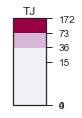

In [133]:
# Output bins used by map (calculated with Fisher Jenks)
fj_bins = np.round(ps.Fisher_Jenks(
    GHG_map.county_data['value'].fillna(0), k = 5
            ).bins / 1000)

cb_ticks = [0]
cb_bound = [0, 200]

for cb_l in [cb_ticks, cb_bound]:
    for v in fj_bins:
        cb_l.append(v)
    
fig = plt.figure(figsize=(0.5, 8))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.colors.ListedColormap(GHG_map.color_bins_hex[5])
#norm = mpl.colors.Normalize(vmin=0)
cb = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=None, values=cb_ticks, boundaries=cb_bound,
                                ticks=cb_bound, spacing='uniform',
                                orientation='vertical')
ax1.set_title('TJ')


GHG_map.color_bins_hex[5]

In [10]:

# Output bins used by map (calculated with Fisher Jenks)
fj_bins = np.round(ps.Fisher_Jenks(
    GHG_map.county_data['value'].fillna(0), k = 7
            ).bins) / 1000

# Color bar
cbar = fig.colorbar(test, ticks=fj_bins)

C:\Users\cmcmilla\AppData\Local\Continuum\Anaconda3\lib\site-packages\bs4\__init__.py:109: UserWarning: BS4 does not respect the selfClosingTags argument to the BeautifulSoup constructor. The tree builder is responsible for understanding self-closing tags.
  "BS4 does not respect the selfClosingTags argument to the "


NameError: name 'fig' is not defined

              Fisher_Jenks             
 
Lower          Upper              Count
        x[i] <= 0.226               439
0.226 < x[i] <= 0.619                89
0.619 < x[i] <= 1.358                21
1.358 < x[i] <= 2.403                10
2.403 < x[i] <= 3.280                 3
3.280 < x[i] <= 7.028                 2
7.028 < x[i] <= 9.376                 1

In [85]:
# Create county map that shows max energy by temperature band.
char_mapdata = pd.melt(
    target_char.groupby(['REPORTING_YEAR', 'COUNTY_FIPS', 'Temp_band'], as_index=False)[['Total', 'MMTCO2E']].sum(),
    id_vars=['REPORTING_YEAR', 'COUNTY_FIPS', 'Temp_band'], value_vars=['Total', 'MMTCO2E']
    )

test = target_char[target_char.REPORTING_YEAR == 2015].groupby(['COUNTY_FIPS', 'Temp_band'])['Total'].sum()

test_dict = dict(test.reset_index()[['Total', 'Temp_band']].values)

pd.concat([test.max(level=0), test.max(level=0).map(test_dict)], axis=1)

,Total,Total
COUNTY_FIPS,,
0,1062.887388,>400°C
1001,6106.379201,100 - 400°C
1015,360.657165,100 - 400°C
1023,2587.510743,>400°C
1025,2988.851584,>400°C
1033,2785.896552,>400°C
1047,5417.186003,>400°C
1053,4191.239764,>400°C
1071,3562.560808,>400°C


In [97]:
# Identify which target industry facilities have increased or decreased emissions since their first reporting year
first_y = GHGRP_emissions.groupby('FACILITY_ID').REPORTING_YEAR.min()

last_y = GHGRP_emissions.groupby('FACILITY_ID').REPORTING_YEAR.max()

trend_ghgs = pd.DataFrame(index = first_y.index, columns = ['FIRST', 'LAST'])

for f, y in first_y.to_dict().items():
    trend_ghgs.loc[f, 'FIRST'] = GHGRP_emissions.groupby(['FACILITY_ID', 'REPORTING_YEAR']).get_group((f,y)).CO2E_EMISSION.sum()
    
for f, y in last_y.to_dict().items():
    trend_ghgs.loc[f, 'LAST'] = GHGRP_emissions.groupby(['FACILITY_ID', 'REPORTING_YEAR']).get_group((f,y)).CO2E_EMISSION.sum()
    
# Drop facilities with only one year of reporting
trend_ghgs = pd.DataFrame(trend_ghgs[first_y != last_y])

trend_ghgs.loc[:, 'DECREASED'] = trend_ghgs.FIRST > trend_ghgs.LAST

In [98]:
# Explore by emissions decile if target industry facilities have decreased emissions
trend_ghgs.loc[:, 'DECREASED'] = trend_ghgs.FIRST > trend_ghgs.LAST

trend_ghgs.loc[:, 'DECILE'] = pd.qcut(trend_ghgs.LAST, 10, retbins=True)[0]

dbins = pd.qcut(trend_ghgs.LAST, 10, retbins=True)[1]

np.round(
    trend_ghgs.groupby(['DECILE', 'DECREASED']).FIRST.count()  / trend_ghgs.groupby(['DECILE']).FIRST.count(), decimals=2
    )

DECILE                     DECREASED
[0.1, 935.596]             False        0.35
                           True         0.65
(935.596, 10457.748]       False        0.27
                           True         0.73
(10457.748, 22046.416]     False        0.21
                           True         0.79
(22046.416, 30877.836]     False        0.31
                           True         0.69
(30877.836, 42007.76]      False        0.54
                           True         0.46
(42007.76, 58938.628]      False        0.56
                           True         0.44
(58938.628, 94755.778]     False        0.60
                           True         0.40
(94755.778, 216153.8]      False        0.52
                           True         0.48
(216153.8, 889573.25]      False        0.50
                           True         0.50
(889573.25, 19247050.048]  False        0.48
                           True         0.52
Name: FIRST, dtype: float64

In [64]:
# Plot fuel fraction of total calculated energy by year and NAICS
sns.set(style = 'ticks')
sns.set_palette('colorblind')
sns.hls_palette(8, l=.3, s=.8)

g_temp = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'FINAL_NAICS_CODE', col_wrap = 4, hue = 'variable', kind='point',
    data = target_eu)


g_temp.set_axis_labels('Reporting Year', 'Fuel Fraction of Total Energy')

ValueError: Could not interpret input 'value'

In [2]:
#Read csv of GHGRP-reported emissions from 2011 to 2015 and create index to 2011.

ghgrp_sector = {
    'abs': pd.read_csv('GHGRP_2011_2015.csv', 
        index_col = 'Sector', thousands = ',')
    }

for c in ghgrp_sector['abs'].columns:
    ghgrp_sector['abs'][c] = ghgrp_sector['abs'][c].astype(
        np.float
        )
    ghgrp_sector['abs'].rename(
        columns = {c: c[0:4]},inplace = True
        )
    
ghgrp_sector['index_2011'] = pd.DataFrame(
    ghgrp_sector['abs'].divide(ghgrp_sector['abs']['2011'], axis = 'index')
    * 100)



NameError: name 'pd' is not defined

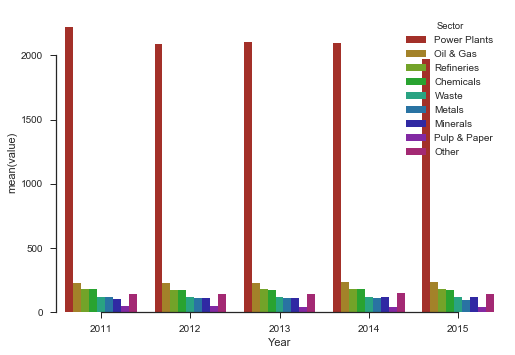

In [107]:
#Plot GHGRP-reported emissions.
#Set Seaborn plot styles
sns.set_style('ticks')
sns.set_context('notebook')
sns.hls_palette(8, l=.3, s=.8)

m_sectors = list(
    ghgrp_sector['index_2011'].index[0:4].values 
    )

for i in ghgrp_sector['index_2011'].index[6:11].values:
    m_sectors.append(i)
    
plt_data = pd.DataFrame(ghgrp_sector['abs'].loc[m_sectors, :])

plt_data.reset_index(inplace = True)

plt_data = pd.melt(plt_data, id_vars = ['Sector'], var_name = ['Year'])

sns.barplot(
    x = 'Year', y = 'value', hue = 'Sector', data = plt_data, palette = sns.hls_palette(9, l=.4, s=.8)
    )

sns.despine(trim = True)